In [51]:
import pandas as pd
import re
import numpy as np
from pyvi import ViTokenizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import json
from keras.models import load_model

In [3]:
# Clean file raw data
# Đường dẫn file CSV
input_file = "Data.csv"
output_file = "DataClean.csv"

# Hàm để làm sạch nội dung
def clean_text(text):
    # Loại bỏ icon hoặc ký tự đặc biệt (chỉ giữ chữ cái, số, khoảng trắng)
    return re.sub(r"[^\w\s]", "", text)

# Đọc file CSV với mã hóa (thay thế "utf-8-sig" bằng mã hóa phù hợp nếu cần)
df = pd.read_csv(input_file, encoding="utf-8-sig")

# Làm sạch từng cột trong DataFrame
for column in df.columns:
    df[column] = df[column].astype(str).apply(clean_text)

# Ghi lại file CSV
df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"Đã xử lý xong, file lưu tại {output_file}")

Đã xử lý xong, file lưu tại DataClean.csv


In [4]:
# Clean + nomalize training data
# Đường dẫn file CSV
input_file = "DataTraining.csv"
output_file = "DataTrainClean.csv"

# Hàm để làm sạch nội dung
def clean_text(text):
    if pd.isna(text):  # Kiểm tra nếu giá trị là NaN
        return ""  
    # Loại bỏ icon hoặc ký tự đặc biệt (chỉ giữ chữ cái, số, khoảng trắng)
    return re.sub(r"[^\w\s]", "", text)

def nomalize(text):
    if pd.isna(text):
        return ""
    return text.lower()
    
# Đọc file CSV với mã hóa 
df = pd.read_csv(input_file, encoding="utf-8-sig")

# Làm sạch từng cột trong DataFrame
for column in df.columns:
    df[column] = df[column].apply(clean_text)  
    df[column] = df[column].apply(nomalize)

# Ghi lại file CSV
df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"Đã xử lý xong, file lưu tại {output_file}")


Đã xử lý xong, file lưu tại DataTrainClean.csv


In [5]:
# Đọc dữ liệu từ file CSV
file_path = 'DataTrainClean.csv' 
data = pd.read_csv(file_path)
data.head()
# Xem dữ liệu 
print(data.head())


                                               Text   \
0   đóe hiểu sao concert chuyển bài mượt như sunsilk   
1  sau mẹ yêu con là áo mùa đông luôn mẹ nuôi con...   
2  sau ckgmdt x gene có thêm 1 đoạn nối để vào kh...   
3  gu t là mấy anh ngưu ma vương chứ mấy em hồng ...   
4  còn chưa kể cảnh kết thúc của thu hoài là gió ...   

                                          Slang Abbreviations  \
0                          mượt như sunsilk đóe           NaN   
1                                           NaN           NaN   
2                                           NaN        ckgmdt   
3  hồng hài nhi ngưu ma vương dưỡng thê dịu kha           NaN   
4                                          thần           NaN   

                                        Text meaning  
0         không hiểu sao concert chuyển bài mượt thế  
1  sau mẹ yêu con là áo mùa đông luôn mẹ nuôi con...  
2  sau có không giữ mất đừng tìm và gene có thêm ...  
3  gu tao là mấy anh lớn tuổi chứ mấy em bé tuổi ...

In [6]:
# Data preprocessing
# Tạo một danh sách chứa các cặp (token, nhãn)
token_label_pairs = []

# Duyệt qua các dòng dữ liệu
for _, row in df.iterrows():
    # Token hóa văn bản từ cột "Text ", thay "_" bằng khoảng trắng và tách thành danh sách từ
    tokens = ViTokenizer.tokenize(row['Text ']).split()  # Tách thành danh sách các từ riêng lẻ
    
    # Tách slang và abbreviation thành danh sách các từ hoặc cụm từ
    slang_tokens =  ViTokenizer.tokenize(row['Slang']).split() if pd.notna(row['Slang']) else []
    abbreviation_tokens = ViTokenizer.tokenize(row['Abbreviations']).split() if pd.notna(row['Abbreviations']) else []
    
    for token in tokens:
        label = "None"  # Mặc định là không có nhãn
        
        # Kiểm tra xem token có phải là slang không
        for slang in slang_tokens:
            if token == slang:  # Nếu token là slang
                label = 'slang'
                break  # Dừng vòng lặp nếu đã tìm thấy slang

        # Kiểm tra xem token có phải là abbreviation không
        for abbr in abbreviation_tokens:
            if token == abbr:  # Nếu token là abbreviation
                # Nếu đã là slang, gộp nhãn lại
                label = 'slang, abbreviation' if label == 'slang' else 'abbreviation'
                break  # Dừng vòng lặp nếu đã tìm thấy abbreviation
        
        # Thêm vào danh sách các cặp token và nhãn
        token_label_pairs.append((token, label, row['Text ']))  

# In ra vài ví dụ
print(token_label_pairs[:20])  # In ra 20 cặp (token, label, text) đầu tiên

# Lưu kết quả vào file
with open("token_label_pairs.json", "w", encoding="utf-8-sig") as file:
    json.dump(token_label_pairs, file, ensure_ascii=False)

[('đóe', 'slang', 'đóe hiểu sao concert chuyển bài mượt như sunsilk'), ('hiểu', 'None', 'đóe hiểu sao concert chuyển bài mượt như sunsilk'), ('sao', 'None', 'đóe hiểu sao concert chuyển bài mượt như sunsilk'), ('concert', 'None', 'đóe hiểu sao concert chuyển bài mượt như sunsilk'), ('chuyển', 'None', 'đóe hiểu sao concert chuyển bài mượt như sunsilk'), ('bài', 'None', 'đóe hiểu sao concert chuyển bài mượt như sunsilk'), ('mượt', 'slang', 'đóe hiểu sao concert chuyển bài mượt như sunsilk'), ('như', 'slang', 'đóe hiểu sao concert chuyển bài mượt như sunsilk'), ('sunsilk', 'slang', 'đóe hiểu sao concert chuyển bài mượt như sunsilk'), ('sau', 'None', 'sau mẹ yêu con là áo mùa đông luôn mẹ nuôi con lớn và lớn lên con đi ra trận'), ('mẹ', 'None', 'sau mẹ yêu con là áo mùa đông luôn mẹ nuôi con lớn và lớn lên con đi ra trận'), ('yêu', 'None', 'sau mẹ yêu con là áo mùa đông luôn mẹ nuôi con lớn và lớn lên con đi ra trận'), ('con', 'None', 'sau mẹ yêu con là áo mùa đông luôn mẹ nuôi con lớn và 

In [7]:
# Mapping words to numbers
def build_word_index(texts):
    word_index = {}
    index = 1  # Bắt đầu từ 1 (0 dành cho padding)
    for text in texts:
        for word in text:
            if word not in word_index:
                word_index[word] = index
                index += 1
    return word_index

# word_index = build_word_index(texts)
word_index = build_word_index([tokens for tokens in df['Text '].apply(lambda x: ViTokenizer.tokenize(x).split())])

# Lưu từ điển để sử dụng lại
with open("word_index.json", "w", encoding='utf-8') as file:
    json.dump(word_index, file, ensure_ascii=False)

In [8]:

# Tạo từ điển ánh xạ nhãn thành chỉ số
label_map = {
    "None": 0,
    "slang": 1,
    "abbreviation": 2,
    "slang, abbreviation": 3
}

# Kiểm tra từ điển nhãn
print("Từ điển label_map:", label_map)

sequences = []  # ID của các token
labels = []

# Duyệt qua các cặp token, label trong token_label_pairs
for token, label, _ in token_label_pairs:
    # Ánh xạ từ token thành chỉ số (sử dụng từ điển 'word_index')
    token_id = word_index.get(token, 0)  # 0 là chỉ số cho padding
    
    sequences.append(token_id)  # Thêm token_id vào danh sách

    # Ánh xạ label thành chỉ số
    label_id = label_map[label]  # Mỗi label là một chỉ số
    labels.append(label_id)

# Convert sequences thành dạng danh sách các chuỗi
sequences = [[seq] for seq in sequences]  # Đảm bảo mỗi token có dạng [token_id]
print("Sequences:", sequences)

# Áp dụng padding cho các chuỗi token
max_length = 121  # Điều chỉnh giá trị max_length cho phù hợp với dữ liệu của bạn
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# In ra kích thước của padded_sequences và labels
print("Padded Sequences Shape:", padded_sequences.shape)  # Sẽ trả về số chuỗi và chiều dài chuỗi
print("Labels:", labels)  # Đảm bảo labels có số phần tử tương ứng

Từ điển label_map: {'None': 0, 'slang': 1, 'abbreviation': 2, 'slang, abbreviation': 3}
Sequences: [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [11], [19], [13], [20], [21], [20], [22], [13], [23], [24], [25], [10], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [18], [40], [41], [14], [42], [43], [44], [45], [46], [42], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [53], [61], [44], [45], [14], [62], [63], [64], [65], [66], [67], [68], [69], [68], [70], [71], [72], [73], [74], [75], [76], [14], [77], [78], [79], [5], [80], [81], [78], [82], [81], [83], [84], [85], [74], [11], [12], [13], [18], [86], [87], [86], [78], [88], [89], [90], [91], [72], [92], [87], [93], [86], [78], [94], [89], [95], [68], [96], [97], [98], [99], [100], [101], [74], [41], [14], [5], [6], [7], [102], [58], [103], [104], [105], [106], [107], [55], [108], [109], [110], [111], [112], 

In [9]:
# Chuyển nhãn thành one-hot
labels_one_hot = to_categorical(labels, num_classes=len(label_map))

# Kiểm tra one-hot encoding
print("Một số nhãn dạng one-hot:", labels_one_hot[:5])  # In 5 nhãn đầu tiên

Một số nhãn dạng one-hot: [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [10]:
vocab_size = len(word_index) + 1  # +1 để đảm bảo bao gồm cả padding
embedding_dim = 100
max_length = 121

In [25]:

model= Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(Conv1D(256, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.45))
model.add(Conv1D(512, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.45))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Flatten())

model.add(Dense(256,kernel_regularizer=regularizers.l2(0.001),activation="relu"))
model.add(Dense(4, activation='softmax'))

adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Xây dựng model với shape đầu vào
model.build(input_shape=(None, max_length))  # max_length là độ dài của chuỗi
model.summary()  # Hiển thị thông tin về model



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 121, 100)       │       325,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 119, 256)       │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 119, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 119, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 117, 512)       │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       295,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,126,628 (4.30 MB)

 Trainable params: 1,126,628 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:

x_train, x_test, y_train, y_test = train_test_split(
    padded_sequences, 
    labels_one_hot, 
    test_size=0.2, 
    random_state=96
    )

In [43]:

history = model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size=512, 
    validation_data=(x_test, y_test), 
)


Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.9346 - loss: 0.1708 - val_accuracy: 0.9374 - val_loss: 0.1553
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.9369 - loss: 0.1601 - val_accuracy: 0.9374 - val_loss: 0.1533
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.9377 - loss: 0.1540 - val_accuracy: 0.9374 - val_loss: 0.1590
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9367 - loss: 0.1494 - val_accuracy: 0.9374 - val_loss: 0.1566
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9347 - loss: 0.1471 - val_accuracy: 0.9525 - val_loss: 0.1633
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.9420 - loss: 0.1399 - val_accuracy: 0.9415 - val_loss: 0.1579
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.9446 - loss: 0.1410 - val_accuracy: 0.9394 - val_loss: 0.1558
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9438 - loss: 0.1312 - val_accuracy: 0.9391 - val_loss:

In [44]:
# Lưu mô hình 
model.save("model_6.keras")

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


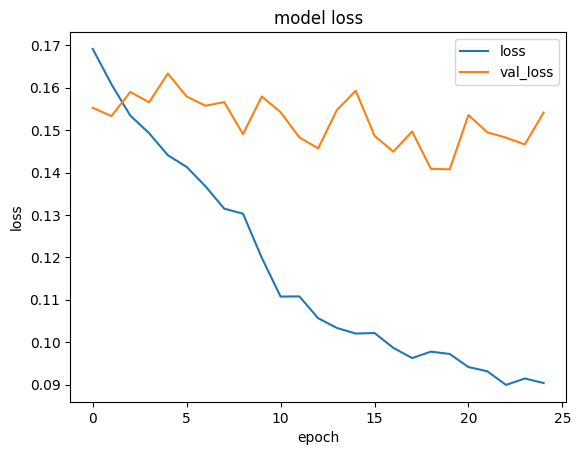

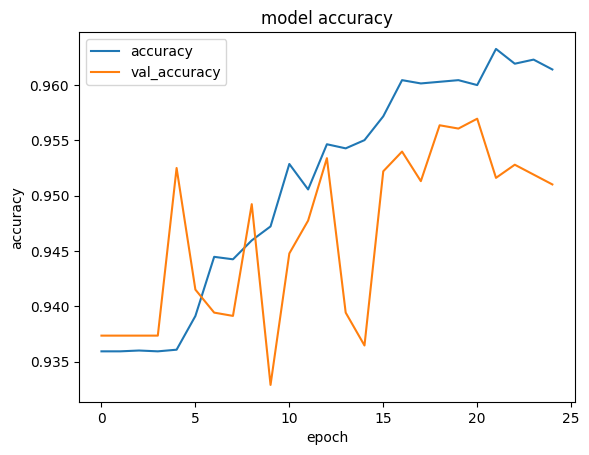

In [45]:
import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.models import load_model

model = load_model("model_6.keras")

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step
Precision: 0.623264265762395
Recall: 0.6898211849126483
F1 Score: 0.6357812544936873


In [54]:
# Tải word_index từ file JSON
with open('word_index.json', 'r', encoding='utf-8') as f:
    word_index = json.load(f)

# Tải mô hình từ file
model = load_model("model_6.keras")

# Ánh xạ nhãn (label_map)
label_map = {
    0: "None",  # Không phải là slang hay viết tắt
    1: "slang",  # Slang
    2: "abbreviation",  # Viết tắt
    3: "slang, abbreviation"  # Cả slang và viết tắt
}

new_sentence = "E iu môn xử lý ngôn ngữ vcl :)))"

# Hàm để làm sạch nội dung
def clean_text(sentence):
    # Loại bỏ icon hoặc ký tự đặc biệt (chỉ giữ chữ cái, số, khoảng trắng)
    return re.sub(r"[^\w\s]", "", sentence)

# Hàm để chuẩn hóa câu
def nomalize(sentence):
    return sentence.lower()

# Áp dụng làm sạch và chuẩn hóa
cleaned_sentence = clean_text(nomalize(new_sentence))

# Tokenize câu mới bằng ViTokenizer
new_tokens = ViTokenizer.tokenize(cleaned_sentence).split()

print(f"Cleaned sentence: '{cleaned_sentence}'")
# Dự đoán cho từng từ trong câu
for idx, word in enumerate(new_tokens):
    # Tìm chỉ số từ trong word_index
    new_token = word_index.get(word, 0)  # Nếu từ không có trong word_index, gán giá trị mặc định là 0
    
    # Chuyển token thành dạng danh sách và padding
    new_padded = pad_sequences([[new_token]], maxlen=121)

    # Dự đoán cho token
    predictions = model.predict(new_padded)

    # Lấy nhãn dự đoán (chỉ số của nhãn có xác suất cao nhất)
    predicted_class = np.argmax(predictions, axis=-1)[0]

    # In kết quả dự đoán cho từ tương ứng
    print(f"Token: '{word}' - Predicted label: {label_map.get(predicted_class, 'Unknown')} - Probability: {predictions[0][predicted_class]:.4f}")


Cleaned sentence: 'e iu môn xử lý ngôn ngữ vcl '
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
Token: 'e' - Predicted label: abbreviation - Probability: 0.8104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Token: 'iu' - Predicted label: abbreviation - Probability: 0.8103
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Token: 'môn' - Predicted label: None - Probability: 0.9986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Token: 'xử_lý' - Predicted label: None - Probability: 0.8416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Token: 'ngôn_ngữ' - Predicted label: None - Probability: 0.8416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Token: 'vcl' - Predicted label: slang - Probability: 0.6105
